In [ ]:
import sys
from pathlib import Path
main_dir = str(Path.cwd().parent)
if main_dir not in sys.path:
    sys.path.append(main_dir)

from environment.market import MarketEnv
from environment.puppet import *
from visualization.env_status import policy_plot, strategy_plot
import matplotlib.pyplot as plt
#logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
from learning.DQN import manual_seed, train
from learning.utils import ReplayMemory
from models.MLP import SimpleBrokerDRL
import random



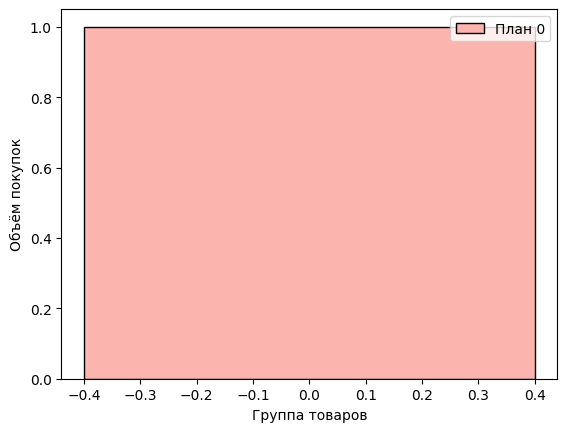

In [24]:
K_GROUPS = 1
K_CONS_GROUPS = 1
K_ADD_GROUPS = 1
K_PUP = 1
K_ACTIONS = 4

cons_list = [ListConsumer(K_GROUPS, K_CONS_GROUPS),
             #ImpulseConsumer(K_GROUPS, K_ADD_GROUPS, add_budget=1, impulse_coef=1.7, impulse_base=0.)
             ]
env = MarketEnv(K_GROUPS, k_actions=K_ACTIONS, fix_stock=10, consumer_list=cons_list, max_ep=2)
policy_plot(env)

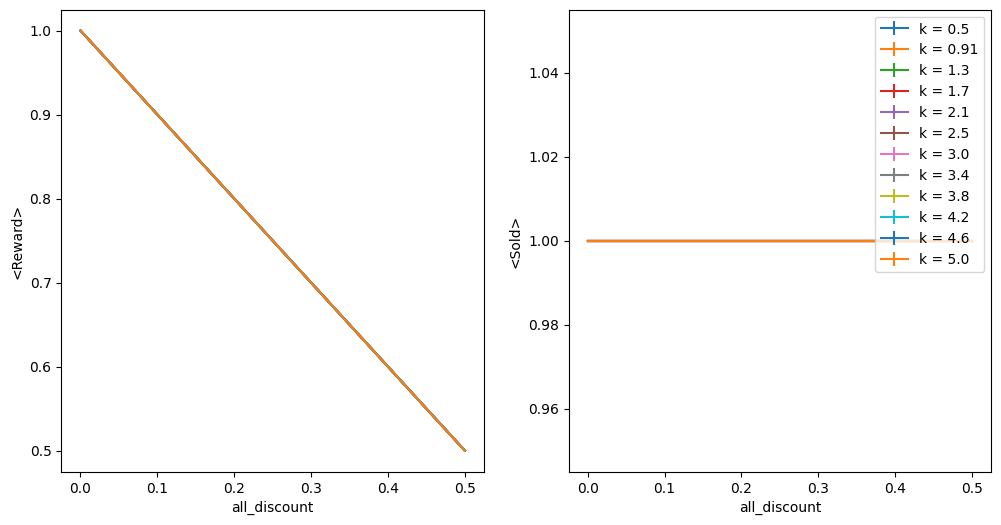

In [25]:
strategy_plot(env)

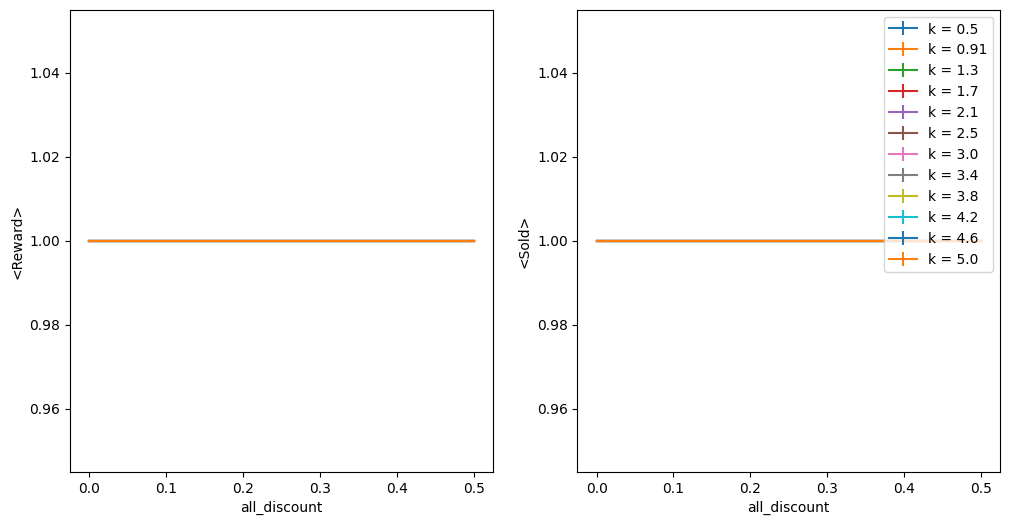

In [26]:
strategy_plot(env, apply_to=np.where(env.add_policy > 0)[0].tolist())

In [27]:
params = {
    'VERSION': 'One_buy_test',
    'BATCH_SIZE': 500,
    'GAMMA': 0.99,
    'EPS_START': 0.95,
    'EPS_END': 0.01,
    'N_EPS': 20000,
    'EPS_DECAY': 17000,
    'REPORT': 500,
    'MEMORY': 2000,
    'LR': 1e-4,
    'TAU': 0.1
    }

manual_seed(2222)
random.seed(2222)

import torch.nn as nn
from torch.optim import Adam


policy_Q=SimpleBrokerDRL(K_GROUPS, K_ACTIONS)
target_Q=SimpleBrokerDRL(K_GROUPS, K_ACTIONS)
target_Q.load_state_dict(policy_Q.state_dict())
# Compute Huber loss
criterion = nn.SmoothL1Loss()
#optimizer = Adagrad(policy_Q.parameters(), lr=params['LR'], lr_decay=1e-6)
optimizer = Adam(policy_Q.parameters(), lr=params['LR'])
device = "cpu"
memory = ReplayMemory(params['MEMORY'])

<Figure size 640x480 with 0 Axes>

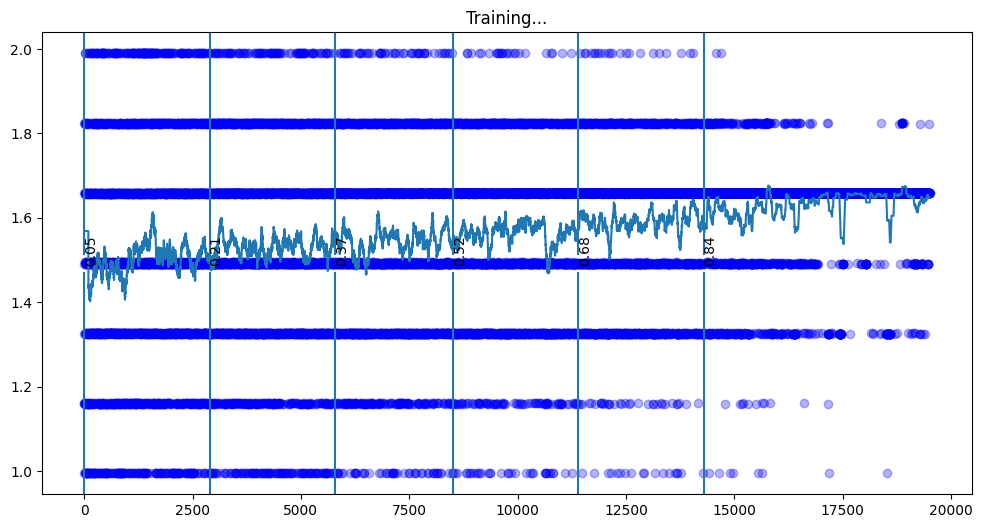

100%|██████████| 20000/20000 [01:15<00:00, 264.35it/s]


Complete


<Figure size 640x480 with 0 Axes>

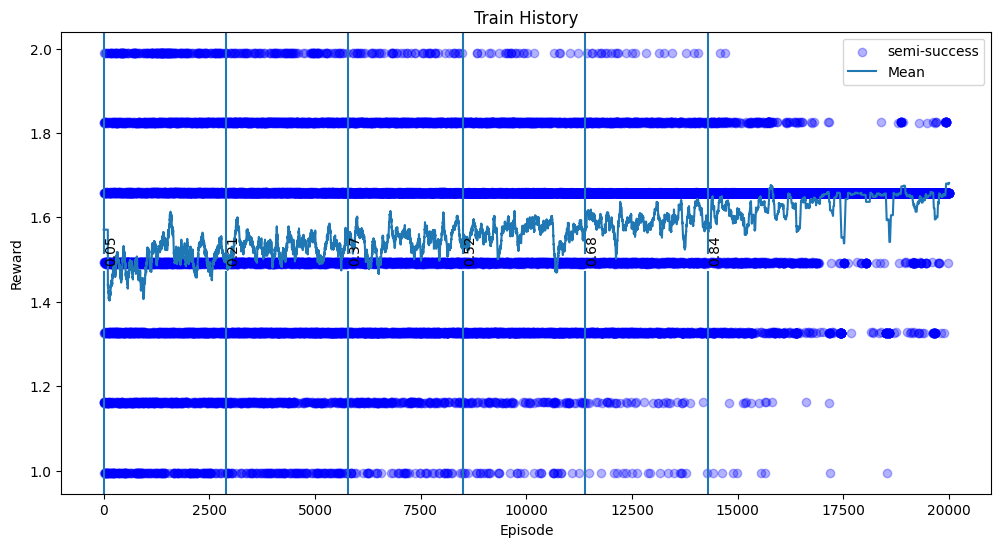

([(1.1616666666666666, True),
  (1.1616666666666666, True),
  (1.4916666666666667, True),
  (1.6583333333333334, True),
  (0.995, True),
  (1.8250000000000002, True),
  (1.1600000000000001, True),
  (1.3250000000000002, True),
  (1.1600000000000001, True),
  (1.6566666666666667, True),
  (1.99, True),
  (1.495, True),
  (1.3250000000000002, True),
  (1.8233333333333333, True),
  (1.6583333333333334, True),
  (1.8233333333333333, True),
  (1.495, True),
  (1.1616666666666666, True),
  (1.1616666666666666, True),
  (1.4916666666666667, True),
  (1.99, True),
  (1.1600000000000001, True),
  (1.1600000000000001, True),
  (1.6583333333333334, True),
  (1.3266666666666667, True),
  (1.8250000000000002, True),
  (0.995, True),
  (1.6583333333333334, True),
  (1.8250000000000002, True),
  (0.995, True),
  (1.6566666666666667, True),
  (1.4933333333333334, True),
  (1.495, True),
  (1.49, True),
  (1.6583333333333334, True),
  (1.8250000000000002, True),
  (0.995, True),
  (1.8250000000000002, 

In [28]:
train(env, policy_Q, target_Q, criterion, optimizer, memory, device, params)

In [11]:
import numpy as np
N = 200
rs = []
env.reset()
for i in range(N):
    end = False
    reward = 0
    while not end:
        _, r0, end, _ = env.step(action=[0]*env.k_groups)
        reward += r0
        break
    rs.append(reward)
    env.reset()
print(f"{np.mean(rs):.2f} +- {np.std(rs) / np.sqrt(N):.2f} ")

1.00 +- 0.00 


In [12]:
import torch
N = 200
rs = []
for i in range(N):
    end = False
    reward = 0
    while not end:
        rews = target_Q(torch.tensor([env.state()[0]], dtype=torch.float32))
        action = rews.argmax(-1)
        action = action.tolist()[0]
        _, r0, end, _ = env.step(action)
        reward += r0
        break
    rs.append(reward)
    env.reset()
print(f"{np.mean(rs):.2f} +- {np.std(rs) / np.sqrt(N):.2f} ")

0.83 +- 0.00 


In [13]:
env.get_discount(action)

array([0.16666667])

In [14]:
rews

tensor([[[30.4376, 30.4498, 30.4267, 30.4257]]], grad_fn=<UnfoldBackward0>)